In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import csv
import numpy as np
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
covidData=pd.read_csv('/content/drive/MyDrive/Data Dissertation/FinalCleansedCovidData.csv')

In [5]:
covidData.head()

,Text,Label,Source
0,0 1g resolution weighing scale for my laborato...,1,Twitter
1,0 5 death rate is the same number that iceland...,1,Twitter
2,0 belonging to adivasi or tribal communities,1,Twitter
3,0 testing,1,Twitter
4,00 heaven james bond legend sean connery dies ...,1,Twitter


In [6]:
print("Count of data in the dataframe:",len(covidData))

Count of data in the dataframe: 101287


In [7]:
covidData['Label'].value_counts()

1    75103
0    26184
Name: Label, dtype: int64

In [8]:
pip install tensorflow keras transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00


In [9]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


In [10]:
from transformers import XLNetTokenizer
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [11]:
sentences = covidData['Text'].values
labels = covidData['Label'].values

In [12]:
print(' Original Text: ', sentences[0])
print('Tokenized: ', xlnet_tokenizer.tokenize(sentences[0]))
print('Token IDs: ', xlnet_tokenizer.convert_tokens_to_ids(xlnet_tokenizer.tokenize(sentences[0])))

 Original Text:  0 1g resolution weighing scale for my laboratory maximum capacity 2kgs nice
Tokenized:  ['▁0', '▁1', 'g', '▁resolution', '▁weighing', '▁scale', '▁for', '▁my', '▁laboratory', '▁maximum', '▁capacity', '▁2', 'kg', 's', '▁nice']
Token IDs:  [700, 156, 299, 2534, 15195, 3389, 28, 94, 7248, 3008, 2314, 159, 13880, 23, 2101]


In [13]:
input_ids = []
attention_masks = []
sentence_ids = []
counter = 0

for sentence in sentences:
    encoded_dict = xlnet_tokenizer.encode_plus(
                        str(sentence),
                        add_special_tokens = True,
                        max_length = 150,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    sentence_ids.append(counter)
    counter  = counter + 1


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

print('Original data IDs: ', sentences[1])
print('Token IDs XLNet:', input_ids[1])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original data IDs:  0 5 death rate is the same number that iceland and germany also produced in their antibody tes
Token IDs XLNet: tensor([    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
          

In [14]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [15]:
from torch.utils.data import TensorDataset, random_split

labels = torch.tensor(labels)

# Add data to TensorDataset.
covid_dataset = TensorDataset(input_ids, attention_masks, labels)
print(len(covid_dataset))

101287


<ipython-input-15-d1aae9706f87>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [16]:
# Train, validation, and test data split
train_size = int(0.7 * len(covid_dataset))
val_size = int(0.1 * len(covid_dataset))
test_size = len(covid_dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(
    covid_dataset, [train_size, val_size, test_size]
)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [ ]:
train_input_ids = []
train_attention_masks = []
for text in train_texts:
    encoded_input = xlnet_tokenizer.encode_plus(str(text), padding='max_length', truncation=True, max_length=150, return_tensors='tf')
    train_input_ids.append(encoded_input['input_ids'])
    train_attention_masks.append(encoded_input['attention_mask'])

train_input_ids = tf.concat(train_input_ids, axis=0)
train_attention_masks = tf.concat(train_attention_masks, axis=0)

val_input_ids = []
val_attention_masks = []
for text in val_texts:
    encoded_input = xlnet_tokenizer.encode_plus(str(text), padding='max_length', truncation=True, max_length=150, return_tensors='tf')
    val_input_ids.append(encoded_input['input_ids'])
    val_attention_masks.append(encoded_input['attention_mask'])

val_input_ids = tf.concat(val_input_ids, axis=0)
val_attention_masks = tf.concat(val_attention_masks, axis=0)

test_input_ids = []
test_attention_masks = []
for text in test_texts:
    encoded_input = xlnet_tokenizer.encode_plus(str(text), padding='max_length', truncation=True, max_length=150, return_tensors='tf')
    test_input_ids.append(encoded_input['input_ids'])
    test_attention_masks.append(encoded_input['attention_mask'])

test_input_ids = tf.concat(test_input_ids, axis=0)
test_attention_masks = tf.concat(test_attention_masks, axis=0)

In [18]:
from transformers import XLNetConfig,XLNetForSequenceClassification

In [19]:
num_labels=2
model_name = 'xlnet-base-cased'
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# # Add a dropout layer
# dropout_prob = 0  # Set the dropout probability as desired

# # Replace the classifier layer with a dropout layer
# model_config = model.config
# model_config.hidden_dropout_prob = dropout_prob

# classifier_dropout_layer = nn.Dropout(dropout_prob)
# model.classifier.dropout = classifier_dropout_layer

# Define your custom classifier with an additional LSTM layer
class CustomClassifierWithLSTM(nn.Module):
    def __init__(self, base_model, num_labels, lstm_hidden_size=128, lstm_num_layers=1):
        super(CustomClassifierWithLSTM, self).__init__()
        self.base_model = base_model
        self.lstm = nn.LSTM(input_size=lstm_hidden_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(lstm_hidden_size * 2, num_labels)  # Multiply by 2 for bidirectional LSTM

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Get the sequence output
        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]  # Take the output of the last timestep
        logits = self.linear(lstm_output)

        return logits

# Instantiate the custom classifier with LSTM
custom_classifier_with_lstm = CustomClassifierWithLSTM(model, num_labels)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_classifier_with_lstm.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomClassifierWithLSTM(
  (base_model): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_featu

In [21]:
#no dropout
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [31]:
#dropout 0.2
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Add a dropout layer
dropout_prob = 0.2  # Set the dropout probability as desired
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob
model_config.attention_probs_dropout_prob = dropout_prob

dropout_layer = nn.Dropout(dropout_prob)

# Replace the existing dropout layers in the model
model.transformer.dropout = dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [20]:
#dropout 0.3
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Add a dropout layer
dropout_prob = 0.3  # Set the dropout probability as desired
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob
model_config.attention_probs_dropout_prob = dropout_prob

dropout_layer = nn.Dropout(dropout_prob)

# Replace the existing dropout layers in the model
model.transformer.dropout = dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [22]:
#dropout 0.4
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Add a dropout layer
dropout_prob = 0.4  # Set the dropout probability as desired
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob
model_config.attention_probs_dropout_prob = dropout_prob

dropout_layer = nn.Dropout(dropout_prob)

# Replace the existing dropout layers in the model
model.transformer.dropout = dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [20]:
#Calculate the performance metrics
def truePositive(predictions, labels):
  return sum([predictions == labels and predictions == 1 for predictions, labels in zip(predictions, labels)])

def trueNegative(predictions, labels):
  return sum([predictions == labels and predictions == 0 for predictions, labels in zip(predictions, labels)])

def falsePositive(predictions, labels):
  return sum([predictions != labels and predictions == 1 for predictions, labels in zip(predictions, labels)])

def falseNegative(predictions, labels):
  return sum([predictions != labels and predictions == 0 for predictions, labels in zip(predictions, labels)])

def metrics(predictions, labels):
  predictions = np.argmax(predictions, axis = 1).flatten()
  labels = labels.flatten()
  tp = truePositive(predictions, labels)
  tn = trueNegative(predictions, labels)
  fp = falsePositive(predictions, labels)
  fn = falseNegative(predictions, labels)
  accuracy = (tp + tn) / len(labels)
  precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return accuracy, precision, recall, specificity

In [24]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                 weight_decay=0.01,
                 correct_bias=False
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from transformers import AdamW
optimizer = AdamW(custom_classifier_with_lstm.parameters(),
                  lr = 2e-5, # default is 5e-5
                  weight_decay=0.01,
                 correct_bias=False
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Tracking variables
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_specificity = []
    train_f1 = []

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        train_logits = train_output.logits.detach().cpu().numpy()
        train_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        t_accuracy, t_precision, t_recall, t_specificity = metrics(train_logits, train_label_ids)
        train_accuracy.append(t_accuracy)

        if t_precision != 'nan': train_precision.append(t_precision)
        if t_recall != 'nan': train_recall.append(t_recall)
        if t_specificity != 'nan': train_specificity.append(t_specificity)
        t_f1 = precision_recall_fscore_support(train_label_ids, np.argmax(train_logits, axis=1), average='weighted')[2]
        train_f1.append(t_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Training Accuracy: {:.4f}'.format(sum(train_accuracy)/len(train_accuracy)))
    print('\t - Training Precision: {:.4f}'.format(sum(train_precision)/len(train_precision)) if len(train_precision)>0 else '\t - Training Precision: NaN')
    print('\t - Training Recall: {:.4f}'.format(sum(train_recall)/len(train_recall)) if len(train_recall)>0 else '\t - Training Recall: NaN')
    print('\t - Training Specificity: {:.4f}\n'.format(sum(train_specificity)/len(train_specificity)) if len(train_specificity)>0 else '\t - Training Specificity: NaN')
    print('\t - Training F1 Score: {:.4f}'.format(sum(train_f1) / len(train_f1)) if len(train_f1) > 0 else '\t - Training F1 Score: NaN')

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_f1 = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        val_logits = eval_output.logits.detach().cpu().numpy()
        val_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        v_accuracy, v_precision, v_recall, v_specificity = metrics(val_logits, val_label_ids)
        val_accuracy.append(v_accuracy)
        if v_precision != 'nan': val_precision.append(v_precision)
        if v_recall != 'nan': val_recall.append(v_recall)
        if v_specificity != 'nan': val_specificity.append(v_specificity)
        v_f1 = precision_recall_fscore_support(val_label_ids, np.argmax(val_logits, axis=1), average='weighted')[2]
        val_f1.append(v_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1 Score: {:.4f}'.format(sum(val_f1) / len(val_f1)) if len(val_f1) > 0 else '\t - Validation F1 Score: NaN')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pytho


	 - Train loss: 0.4314
	 - Training Accuracy: 0.8123
	 - Training Precision: 0.8246
	 - Training Recall: 0.9692
	 - Training Specificity: 0.3619

	 - Training F1 Score: 0.7576


Epoch:  50%|█████     | 1/2 [09:58<09:58, 598.71s/it]


	 - Train loss: 0.4314
	 - Validation Accuracy: 0.9286
	 - Validation Precision: 0.9591
	 - Validation Recall: 0.9449
	 - Validation Specificity: 0.8806

	 - Validation F1 Score: 0.9291

	 - Train loss: 0.1709
	 - Training Accuracy: 0.9361
	 - Training Precision: 0.9467
	 - Training Recall: 0.9685
	 - Training Specificity: 0.8439

	 - Training F1 Score: 0.9349


Epoch: 100%|██████████| 2/2 [19:54<00:00, 597.07s/it]


	 - Train loss: 0.1709
	 - Validation Accuracy: 0.9209
	 - Validation Precision: 0.9863
	 - Validation Recall: 0.9063
	 - Validation Specificity: 0.9619

	 - Validation F1 Score: 0.9241


In [22]:
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support
epochs = 2
criterion = nn.CrossEntropyLoss()
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Tracking variables
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_specificity = []
    train_f1 = []

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,b_input_mask,
                             labels = b_labels)

        # Backward pass
        loss = criterion(train_output.logits, b_labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        train_logits = train_output.logits.detach().cpu().numpy()
        train_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        t_accuracy, t_precision, t_recall, t_specificity = metrics(train_logits, train_label_ids)
        train_accuracy.append(t_accuracy)

        if t_precision != 'nan': train_precision.append(t_precision)
        if t_recall != 'nan': train_recall.append(t_recall)
        if t_specificity != 'nan': train_specificity.append(t_specificity)
        t_f1 = precision_recall_fscore_support(train_label_ids, np.argmax(train_logits, axis=1), average='weighted')[2]
        train_f1.append(t_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Training Accuracy: {:.4f}'.format(sum(train_accuracy)/len(train_accuracy)))
    print('\t - Training Precision: {:.4f}'.format(sum(train_precision)/len(train_precision)) if len(train_precision)>0 else '\t - Training Precision: NaN')
    print('\t - Training Recall: {:.4f}'.format(sum(train_recall)/len(train_recall)) if len(train_recall)>0 else '\t - Training Recall: NaN')
    print('\t - Training Specificity: {:.4f}\n'.format(sum(train_specificity)/len(train_specificity)) if len(train_specificity)>0 else '\t - Training Specificity: NaN')
    print('\t - Training F1 Score: {:.4f}'.format(sum(train_f1) / len(train_f1)) if len(train_f1) > 0 else '\t - Training F1 Score: NaN')

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_f1 = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,b_input_mask)
        val_logits = eval_output.logits.detach().cpu().numpy()
        val_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        v_accuracy, v_precision, v_recall, v_specificity = metrics(val_logits, val_label_ids)
        val_accuracy.append(v_accuracy)
        if v_precision != 'nan': val_precision.append(v_precision)
        if v_recall != 'nan': val_recall.append(v_recall)
        if v_specificity != 'nan': val_specificity.append(v_specificity)
        v_f1 = precision_recall_fscore_support(val_label_ids, np.argmax(val_logits, axis=1), average='weighted')[2]
        val_f1.append(v_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1 Score: {:.4f}'.format(sum(val_f1) / len(val_f1)) if len(val_f1) > 0 else '\t - Validation F1 Score: NaN')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pytho


	 - Train loss: 0.1859
	 - Training Accuracy: 0.9271
	 - Training Precision: 0.9380
	 - Training Recall: 0.9688
	 - Training Specificity: 0.8071

	 - Training F1 Score: 0.9212


Epoch:  50%|█████     | 1/2 [09:54<09:54, 594.41s/it]


	 - Train loss: 0.1859
	 - Validation Accuracy: 0.9493
	 - Validation Precision: 0.9785
	 - Validation Recall: 0.9529
	 - Validation Specificity: 0.9408

	 - Validation F1 Score: 0.9504

	 - Train loss: 0.0906
	 - Training Accuracy: 0.9684
	 - Training Precision: 0.9738
	 - Training Recall: 0.9839
	 - Training Specificity: 0.9240

	 - Training F1 Score: 0.9680


Epoch: 100%|██████████| 2/2 [19:47<00:00, 593.71s/it]


	 - Train loss: 0.0906
	 - Validation Accuracy: 0.9627
	 - Validation Precision: 0.9660
	 - Validation Recall: 0.9846
	 - Validation Specificity: 0.8997

	 - Validation F1 Score: 0.9620


In [23]:
predicted_labels = []
for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)

    with torch.no_grad():
        batch_logits = model(batch_input_ids, batch_attention_mask).logits
        batch_probabilities = torch.softmax(batch_logits, dim=1)
        batch_predicted_classes = torch.argmax(batch_probabilities, dim=1)
        predicted_labels.extend(batch_predicted_classes.cpu().tolist())

print(predicted_labels)

[0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 

In [24]:
# Obtain the ground truth labels
ground_truth_labels = [sample[2] for sample in test_dataset]

# Calculate the number of correct predictions
correct_predictions = sum(predicted_label == ground_truth_label for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))

# Calculate the total number of predictions
total_predictions = len(ground_truth_labels)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Calculate true positives, true negatives, false positives, false negatives
true_positives = sum((predicted_label == 1) and (ground_truth_label == 1) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('TP: ',true_positives)
true_negatives = sum((predicted_label == 0) and (ground_truth_label == 0) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('TN: ',true_negatives)
false_positives = sum((predicted_label == 1) and (ground_truth_label == 0) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('FP: ',false_positives)
false_negatives = sum((predicted_label == 0) and (ground_truth_label == 1) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('FN: ',false_negatives)

# Calculate precision
precision = true_positives / (true_positives + false_positives)

# Calculate recall (sensitivity)
recall = true_positives / (true_positives + false_negatives)

# Calculate specificity
specificity = true_negatives / (true_negatives + false_positives)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
# Print the F1 score
print("F1 Score:", f1_score)

TP:  tensor(14841)
TN:  tensor(4658)
FP:  tensor(570)
FN:  tensor(190)
Accuracy: tensor(0.9625)
Precision: tensor(0.9630)
Recall: tensor(0.9874)
Specificity: tensor(0.8910)
F1 Score: tensor(0.9750)


In [25]:
test_predicted_probabilities = []
model.eval()
for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)

    with torch.no_grad():
        logits = model(batch_input_ids, batch_attention_mask).logits
        probabilities = torch.softmax(logits, dim=1)

    # Extract the probabilities for the positive class (assuming binary classification)
    positive_probabilities = probabilities[:, 1]

    # Append the probabilities to the list
    test_predicted_probabilities.extend(positive_probabilities.to(device).tolist())

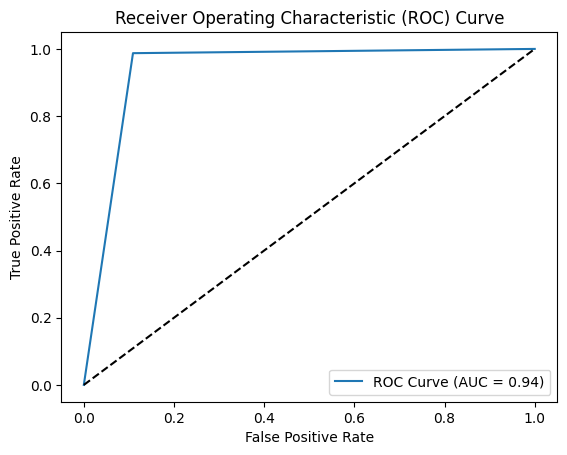

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(ground_truth_labels, predicted_labels)

# Calculate the AUC score
auc_score = roc_auc_score(ground_truth_labels, predicted_labels)



# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(auc_score)

0.9391655740085638


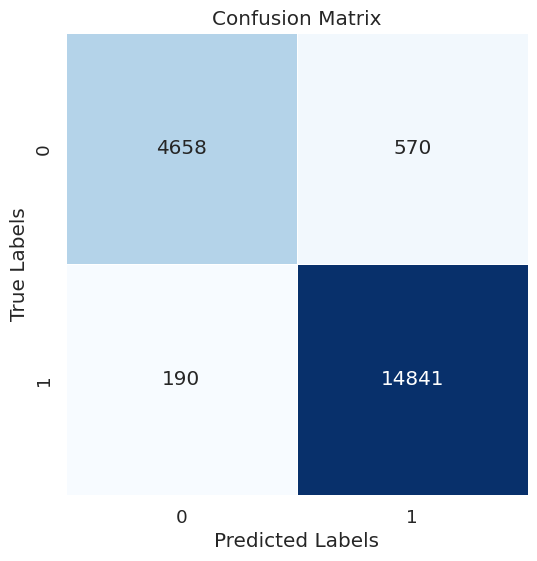

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False, square=True, linewidths=.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()